<a href="https://colab.research.google.com/github/hoo0681/Fastest_Positional_Encoding/blob/main/Fastest_Positional_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Offline contributor: @sjusju

In [9]:
import numpy as np
from numba import jit

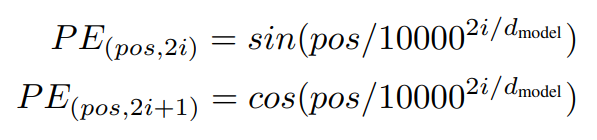

In [10]:
@jit(nopython=True, parallel=True,cache=False)
def GetPE0(Length,model_dim, n=10000):
  PE=np.zeros((Length,model_dim))
  for pos in range(Length):
    for i in range(model_dim):
      ang=pos/(np.power(n,2*(i//2)/model_dim))
      if i%2==0:
        PE[pos][i]=np.sin(ang)
      else:
        PE[pos][i]=np.cos(ang)
  return PE

In [11]:
def GetPE(Length,model_dim, n=10000):
  PE=np.zeros((Length,model_dim))
  for pos in range(Length):
    for i in range(model_dim):
      if i%2==0:
        PE[pos][i]=np.sin(pos/(np.power(n,2*(i//2)/model_dim)))
      else:
        PE[pos][i]=np.cos(pos/(np.power(n,2*(i//2)/model_dim)))
  return PE

In [12]:
def GetPE2(Length,model_dim, n=10000):
  PE=np.array([[pos/np.power(n,2*(i//2)/model_dim) for i in range(model_dim)] for pos in range(Length)])
  PE[:,0::2]=np.sin(PE[:,0::2])
  PE[:,1::2]=np.cos(PE[:,1::2])
  return PE

In [13]:
def GetPE3(Length,model_dim, n=10000):
  PE=np.zeros((Length,model_dim))
  for pos in range(Length):
    for i in range(model_dim):
      tmp=pos/(np.power(n,2*(i//2)/model_dim))
      PE[pos][2*(i//2)]=np.sin(tmp)
      PE[pos][2*(i//2)+1]=np.cos(tmp)
  return PE

In [14]:
def GetPE4(Length, model_dim, n=10000):
  if model_dim & 1:
    model_dim += 1
  tmp = np.exp(1j * np.outer(np.arange(Length), np.power(1 / n, np.linspace(0, 1, model_dim // 2, endpoint = False))))
  PE = np.empty((Length, model_dim))
  PE[:, 0::2] = tmp.imag
  PE[:, 1::2] = tmp.real
  return PE

In [15]:
def GetPE5(Length, model_dim, n=10000):
  if model_dim & 1:
    model_dim += 1
  tmp = np.exp(1j * np.power(1 / n, np.linspace(0, 1, model_dim // 2, endpoint=False)))
  PE = np.empty((Length, model_dim))
  pow = np.ones_like(tmp)
  for i in range(Length):
    PE[i, 0::2] = pow.imag
    PE[i, 1::2] = pow.real
    pow *= tmp
  return PE


In [16]:
def get_sinusoid_encoding_table(n_seq, d_hidn,n=10000):
  """https://gist.github.com/platfarminc/9c646e7d9a1214f204ad5995b1376c95"""
  def cal_angle(position, i_hidn):
    return position / np.power(n, 2 * (i_hidn // 2) / d_hidn)
  def get_posi_angle_vec(position):
    return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

  sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
  sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

  return sinusoid_table

In [17]:
def getPositionEncoding(seq_len, d, n=10000):
  """https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/"""
  P = np.zeros((seq_len, d))
  for k in range(seq_len):
    for i in np.arange(int(d/2)):
      denominator = np.power(n, 2*i/d)
      P[k, 2*i] = np.sin(k/denominator)
      P[k, 2*i+1] = np.cos(k/denominator)
  return P

In [20]:
%%timeit
GetPE0(512,512)

10 loops, best of 5: 34.6 ms per loop


In [21]:
%%timeit
GetPE(512,512)

1 loop, best of 5: 1.14 s per loop


In [22]:
%%timeit
GetPE2(512,512)

1 loop, best of 5: 668 ms per loop


In [23]:
%%timeit
GetPE3(512,512)

1 loop, best of 5: 1.63 s per loop


In [24]:
%%timeit
GetPE4(512,512)

100 loops, best of 5: 10.2 ms per loop


In [25]:
%%timeit
GetPE5(512,512)

100 loops, best of 5: 2.25 ms per loop


In [26]:
%%timeit
get_sinusoid_encoding_table(512,512)

1 loop, best of 5: 686 ms per loop


In [27]:
%%timeit
getPositionEncoding(512,512)

1 loop, best of 5: 941 ms per loop


In [33]:
import tracemalloc
import pandas as pd
import time
"""https://www.analyticsvidhya.com/blog/2021/01/python-code-performance-measurement-measure-the-right-metric-to-optimize-better/"""

def tracing_start():
    tracemalloc.stop()
    print("nTracing Status : ", tracemalloc.is_tracing())
    tracemalloc.start()
    print("Tracing Status : ", tracemalloc.is_tracing())
def tracing_mem():
    first_size, first_peak = tracemalloc.get_traced_memory()
    peak = first_peak/(1024*1024)
    print("Peak Size in MB - ", peak)

def Measurement(func):
  tracing_start()
  start = time.time()
  func(512,512)
  end = time.time()
  print("time elapsed {} milli seconds".format((end-start)*1000))
  tracing_mem()

In [34]:
Measurement(GetPE0)

nTracing Status :  False
Tracing Status :  True
time elapsed 49.025535583496094 milli seconds
Peak Size in MB -  2.0056724548339844


In [37]:
Measurement(GetPE)

nTracing Status :  False
Tracing Status :  True
time elapsed 2061.8302822113037 milli seconds
Peak Size in MB -  2.061333656311035


In [45]:
Measurement(GetPE2)

nTracing Status :  False
Tracing Status :  True
time elapsed 1095.616102218628 milli seconds
Peak Size in MB -  10.112605094909668


In [39]:
Measurement(GetPE3)

nTracing Status :  False
Tracing Status :  True
time elapsed 2937.495470046997 milli seconds
Peak Size in MB -  2.0729122161865234


In [40]:
Measurement(GetPE4)

nTracing Status :  False
Tracing Status :  True
time elapsed 17.827272415161133 milli seconds
Peak Size in MB -  4.006752014160156


In [35]:
Measurement(GetPE5)

nTracing Status :  False
Tracing Status :  True
time elapsed 8.203744888305664 milli seconds
Peak Size in MB -  2.013591766357422


In [41]:
Measurement(get_sinusoid_encoding_table)

nTracing Status :  False
Tracing Status :  True
time elapsed 1353.5254001617432 milli seconds
Peak Size in MB -  10.113693237304688


In [42]:
Measurement(getPositionEncoding)

nTracing Status :  False
Tracing Status :  True
time elapsed 1963.555097579956 milli seconds
Peak Size in MB -  2.056227684020996
